In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
IMGSZ = 256
B_SIZE = 32
CHANNEL_SIZE = 3
EPOCHS = 50

In [3]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    "PEPPER DATASETS",
    image_size=(IMGSZ,IMGSZ),
    shuffle=True,
    batch_size=B_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
CLASS_NAMES = datasets.class_names
CLASS_NAMES

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

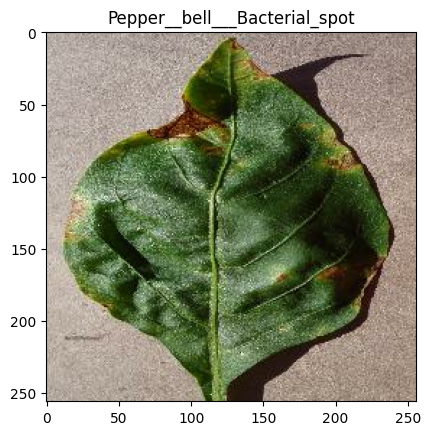

In [5]:
for image_batch, label_batch in datasets.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[label_batch[0]])

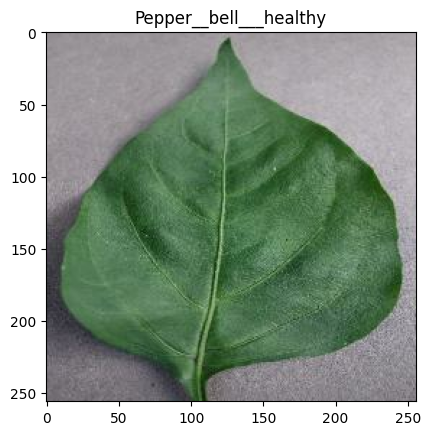

In [6]:
for image_batch, label_batch in datasets.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[label_batch[0]])

In [7]:
def get_train_test_eval_dataset(datasets, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    assert (train_size + test_size + val_size) == 1
    
    ds_size = len(datasets)
    
    if shuffle:
        datasets = datasets.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_size * ds_size)
    val_size = int(val_size * ds_size)
    
    train_dataset = datasets.take(train_size)    
    val_dataset = datasets.skip(train_size).take(val_size)
    test_dataset = datasets.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_train_test_eval_dataset(datasets)

print("LENGTH OF TRAIN DATASET : ",len(train_dataset))
print("LENGTH OF TEST DATASET : ",len(test_dataset))
print("LENGTH OF EVAL DATASET : ",len(val_dataset))

LENGTH OF TRAIN DATASET :  62
LENGTH OF TEST DATASET :  9
LENGTH OF EVAL DATASET :  7


In [8]:
train_dataset = train_dataset.cache().shuffle(1000)
test_dataset = test_dataset.cache().shuffle(1000)
val_dataset = val_dataset.cache().shuffle(1000)

In [9]:
def preprocess_dataset(image, label):
    image = tf.image.resize(image, [IMGSZ, IMGSZ])
    image = image / 255.0
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

train_dataset = train_dataset.map(preprocess_dataset)
val_dataset = val_dataset.map(preprocess_dataset)


pepper_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape = (IMGSZ,IMGSZ,CHANNEL_SIZE)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(2,activation="softmax")
])


# QUANTIZATION WONT WORKS
# pepper_model = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Resizing(IMGSZ,IMGSZ),
#     tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255),
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape = (IMGSZ,IMGSZ,CHANNEL_SIZE)),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64,activation="relu"),
#     tf.keras.layers.Dense(2,activation="softmax")
# ])

In [10]:
import tensorflow_model_optimization as tfmot

pepper_model.build(input_shape=(IMGSZ, IMGSZ, CHANNEL_SIZE))

Quantized_model = tfmot.quantization.keras.quantize_model
Quant_Aware_Model = Quantized_model(pepper_model)

Quant_Aware_Model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Quant_Aware_Model.summary()

history_rec = Quant_Aware_Model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=B_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 256, 256, 3)      3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 254, 254, 32)     963       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 127, 127, 32)     1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 125, 125, 64)     18627     
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_1 (Quan  (None, 62, 62, 64)       1

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(Quant_Aware_Model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
PEPPER_tf_lite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Anandhu\AppData\Local\Temp\tmpigp6gefq\assets


INFO:tensorflow:Assets written to: C:\Users\Anandhu\AppData\Local\Temp\tmpigp6gefq\assets
C:\Users\Anandhu\AppData\Roaming\Python\Python310\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [12]:
with open("PEPPER_tflite_Qaware_model.ftile","wb") as f:
    f.write(PEPPER_tf_lite_qaware_model)

In [13]:
accuracy_pm = history_rec.history['accuracy']
loss_pm = history_rec.history['loss']
val_accuracy_pm = history_rec.history['val_accuracy']
val_loss_pm = history_rec.history['val_loss']

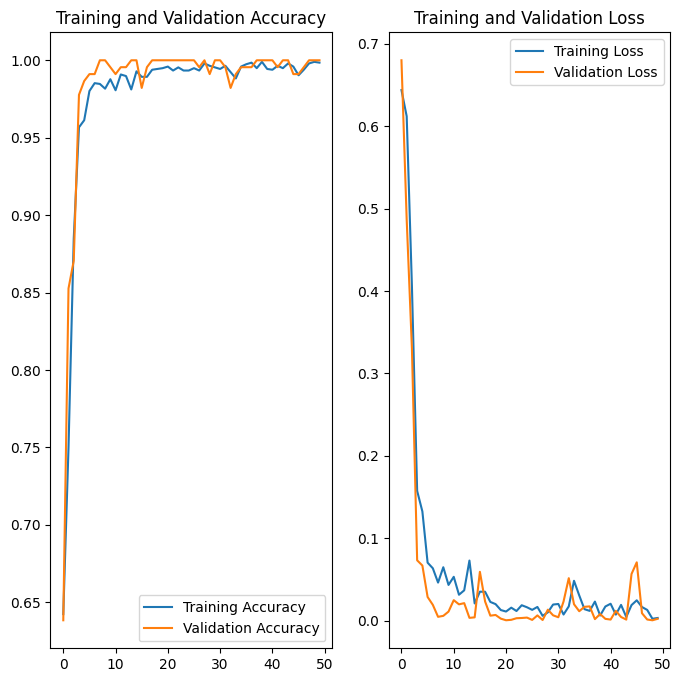

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), accuracy_pm, label='Training Accuracy')
plt.plot(range(50), val_accuracy_pm, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss_pm, label='Training Loss')
plt.plot(range(50), val_loss_pm, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
Quant_Aware_Model.evaluate(test_dataset)

9/9 [==============================] - 4s 388ms/step - loss: 5.7449 - accuracy: 0.4444


[5.744855880737305, 0.4444444477558136]

1/1 [==============================] - 0s 37ms/step


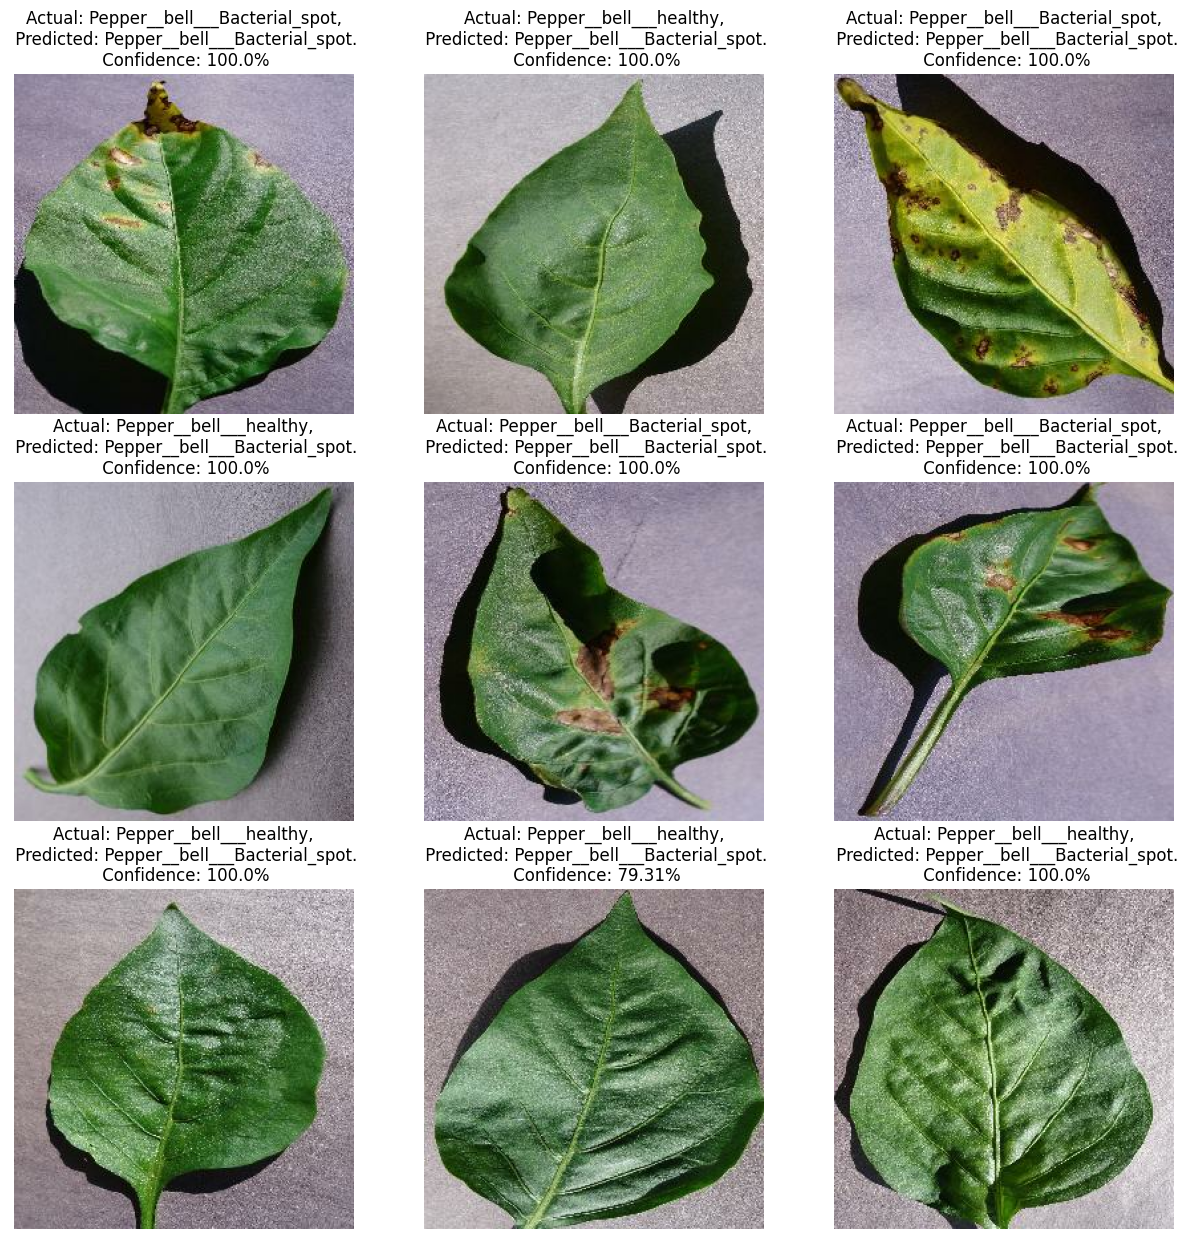

In [19]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        IMG = images[i].numpy()
        plt.imshow(IMG.astype("uint8"))

        img_array = tf.expand_dims(IMG, 0)

        predictions = Quant_Aware_Model.predict(img_array)

        predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
        confidence = round(100 * (np.max(predictions[0])), 2)
        actual_class = CLASS_NAMES[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")